In [6]:
import os
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.optimize import least_squares
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt

In [7]:
PLOT_DATA = '../data/interim/plot_info_for_climatena.csv'
locations = pd.read_csv(PLOT_DATA).rename({'ID1': 'PLOT_ID', 'el': 'ELEV'}, axis=1).set_index('PLOT_ID')
locations.columns = [col.upper() for col in locations.columns]
locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID2     0 non-null      float64
 1   LAT     12156 non-null  float64
 2   LON     12156 non-null  float64
 3   ELEV    12156 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 474.8 KB


In [8]:
CLOUD_DATA = '../data/interim/MODIS_monthly_cloud_fraction.csv'
cloud = pd.read_csv(CLOUD_DATA)
cloud = cloud.set_index(['PLOT_ID', 'PERIOD'])
cloud.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3172716 entries, (60101550679.0, '2000-02') to (530906597320.0, '2021-12')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   CLOUDS  float64
dtypes: float64(1)
memory usage: 36.7+ MB


In [9]:
SUN_DATA = '../data/interim/monthly_irradiance_for_plots.csv'
sun = pd.read_csv(SUN_DATA)
sun = sun.set_index(['PLOT_ID', 'PERIOD'])
sun.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4667904 entries, (60101551969, '1990-01') to (530907572668, '2021-12')
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   POA_GLOBAL          float64
 1   POA_DIRECT          float64
 2   POA_DIFFUSE         float64
 3   POA_SKY_DIFFUSE     float64
 4   POA_GROUND_DIFFUSE  float64
 5   CLEARSKY_GHI        float64
 6   CLEARSKY_DNI        float64
 7   CLEARSKY_DHI        float64
dtypes: float64(8)
memory usage: 303.1+ MB


In [10]:
CLIM_DATA = '../data/interim/climatena_1990-2020_monthly_long.csv'
clim = pd.read_csv(CLIM_DATA).set_index(['PLOT_ID', 'PERIOD'])['RH']
clim.info()

<class 'pandas.core.series.Series'>
MultiIndex: 4522032 entries, (60101550679, '1990-01') to (530907572668, '2020-12')
Series name: RH
Non-Null Count    Dtype
--------------    -----
4522032 non-null  int64
dtypes: int64(1)
memory usage: 52.1+ MB


In [12]:
obs = pd.merge(clim, cloud, how='inner', left_index=True, right_index=True).merge(sun, how='inner', left_index=True, right_index=True)
obs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3039000 entries, (60101550679, '2000-02') to (530907572668, '2020-12')
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   RH                  int64  
 1   CLOUDS              float64
 2   POA_GLOBAL          float64
 3   POA_DIRECT          float64
 4   POA_DIFFUSE         float64
 5   POA_SKY_DIFFUSE     float64
 6   POA_GROUND_DIFFUSE  float64
 7   CLEARSKY_GHI        float64
 8   CLEARSKY_DNI        float64
 9   CLEARSKY_DHI        float64
dtypes: float64(9), int64(1)
memory usage: 243.8+ MB


In [13]:
def pred_cloud_cover(intercept, slope_rh, slope_elev, relative_humidity, elevation, clip_clouds=False):
    cloud_cover = intercept + slope_rh * relative_humidity + slope_elev * elevation
    if clip_clouds:
        cloud_cover = np.clip(cloud_cover, 0,1)
    return cloud_cover

def cloud_cover_correction(clearsky_ghi, cloud_cover, offset=0.35):
    ghi = clearsky_ghi*(offset + (1-offset)*(1-cloud_cover))
    return ghi

def pred_cloudy_ghi(intercept, slope_rh, slope_elev, relative_humidity, elevation, clearsky_ghi, clip_clouds=False):
    cloud_cover = pred_cloud_cover(intercept, slope_rh, slope_elev, relative_humidity, elevation, clip_clouds=clip_clouds)
    return cloud_cover_correction(clearsky_ghi, cloud_cover)
    
def cloudy_ghi_resid(coefs, relative_humidity, elevation, cloud_obs, clearsky_ghi, clip_clouds=False):
    intercept, slope_rh, slope_elev = coefs
    pred = pred_cloudy_ghi(intercept, slope_rh, slope_elev, relative_humidity, elevation, clearsky_ghi, clip_clouds=clip_clouds)
    obs = cloud_cover_correction(clearsky_ghi, cloud_obs)
    return pred - obs
    
def fit_linear_cloud(plot_id):
    res = least_squares(cloudy_ghi_resid, 
                        x0=(-0.5, 0.05, 0.0),
                        args=(obs.loc[plot_id, 'RH'].values, 
                              locations.loc[plot_id, 'ELEV'],
                              obs.loc[plot_id, 'CLOUDS'].values, 
                              obs.loc[plot_id, 'CLEARSKY_GHI'].values),
                        bounds=((-np.inf, 0.01, 0), (np.inf, 0.05, np.inf)),
                        xtol=1e-15
                       )
    return plot_id, res

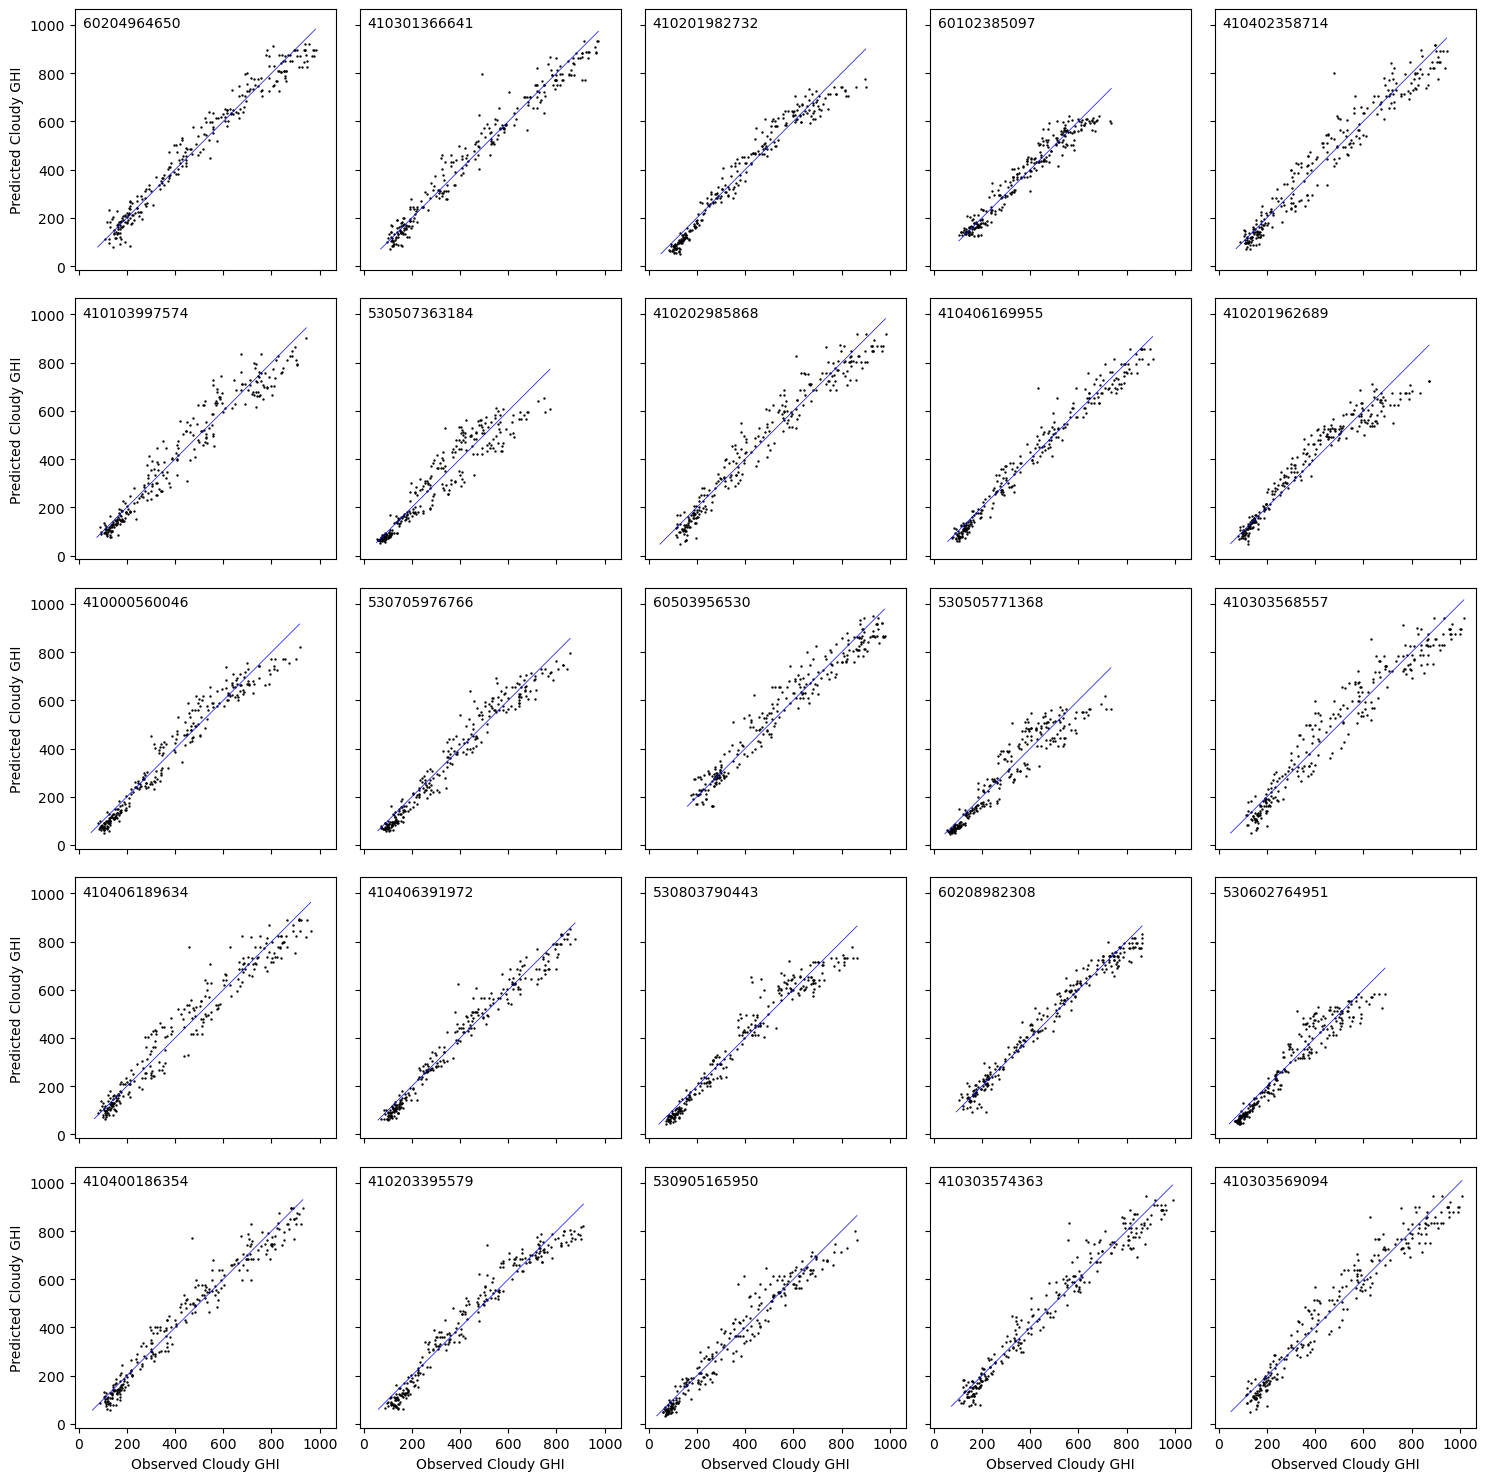

In [14]:
fig, axs = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 25)
for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    x = cloud_cover_correction(obs.loc[plot, 'CLEARSKY_GHI'].values, obs.loc[plot, 'CLOUDS'].values)
    y = pred_cloudy_ghi(coefs[0], coefs[1], coefs[2], 
                        obs.loc[plot, 'RH'].values, 
                        locations.loc[plot, 'ELEV'],
                        obs.loc[plot, 'CLEARSKY_GHI'].values)
    axs.ravel()[i].scatter(x, y, color='black', s=0.5)
    axs.ravel()[i].set_aspect('equal')
    minval = min(x.min(), y.min())
    maxval = max(x.max(), y.max())
    axs.ravel()[i].plot((minval, maxval), (minval, maxval), color='blue', lw=0.5)
    axs.ravel()[i].text(0.03, 0.93, plot, transform=axs.ravel()[i].transAxes)

for ax in axs[-1,:]:
    ax.set_xlabel('Observed Cloudy GHI')
for ax in axs[:,0]:
    ax.set_ylabel('Predicted Cloudy GHI')

plt.tight_layout()
plt.savefig('../reports/figures/observed_predicted_cloudy_ghi.png', dpi=300, bbox_inches='tight')
plt.show()

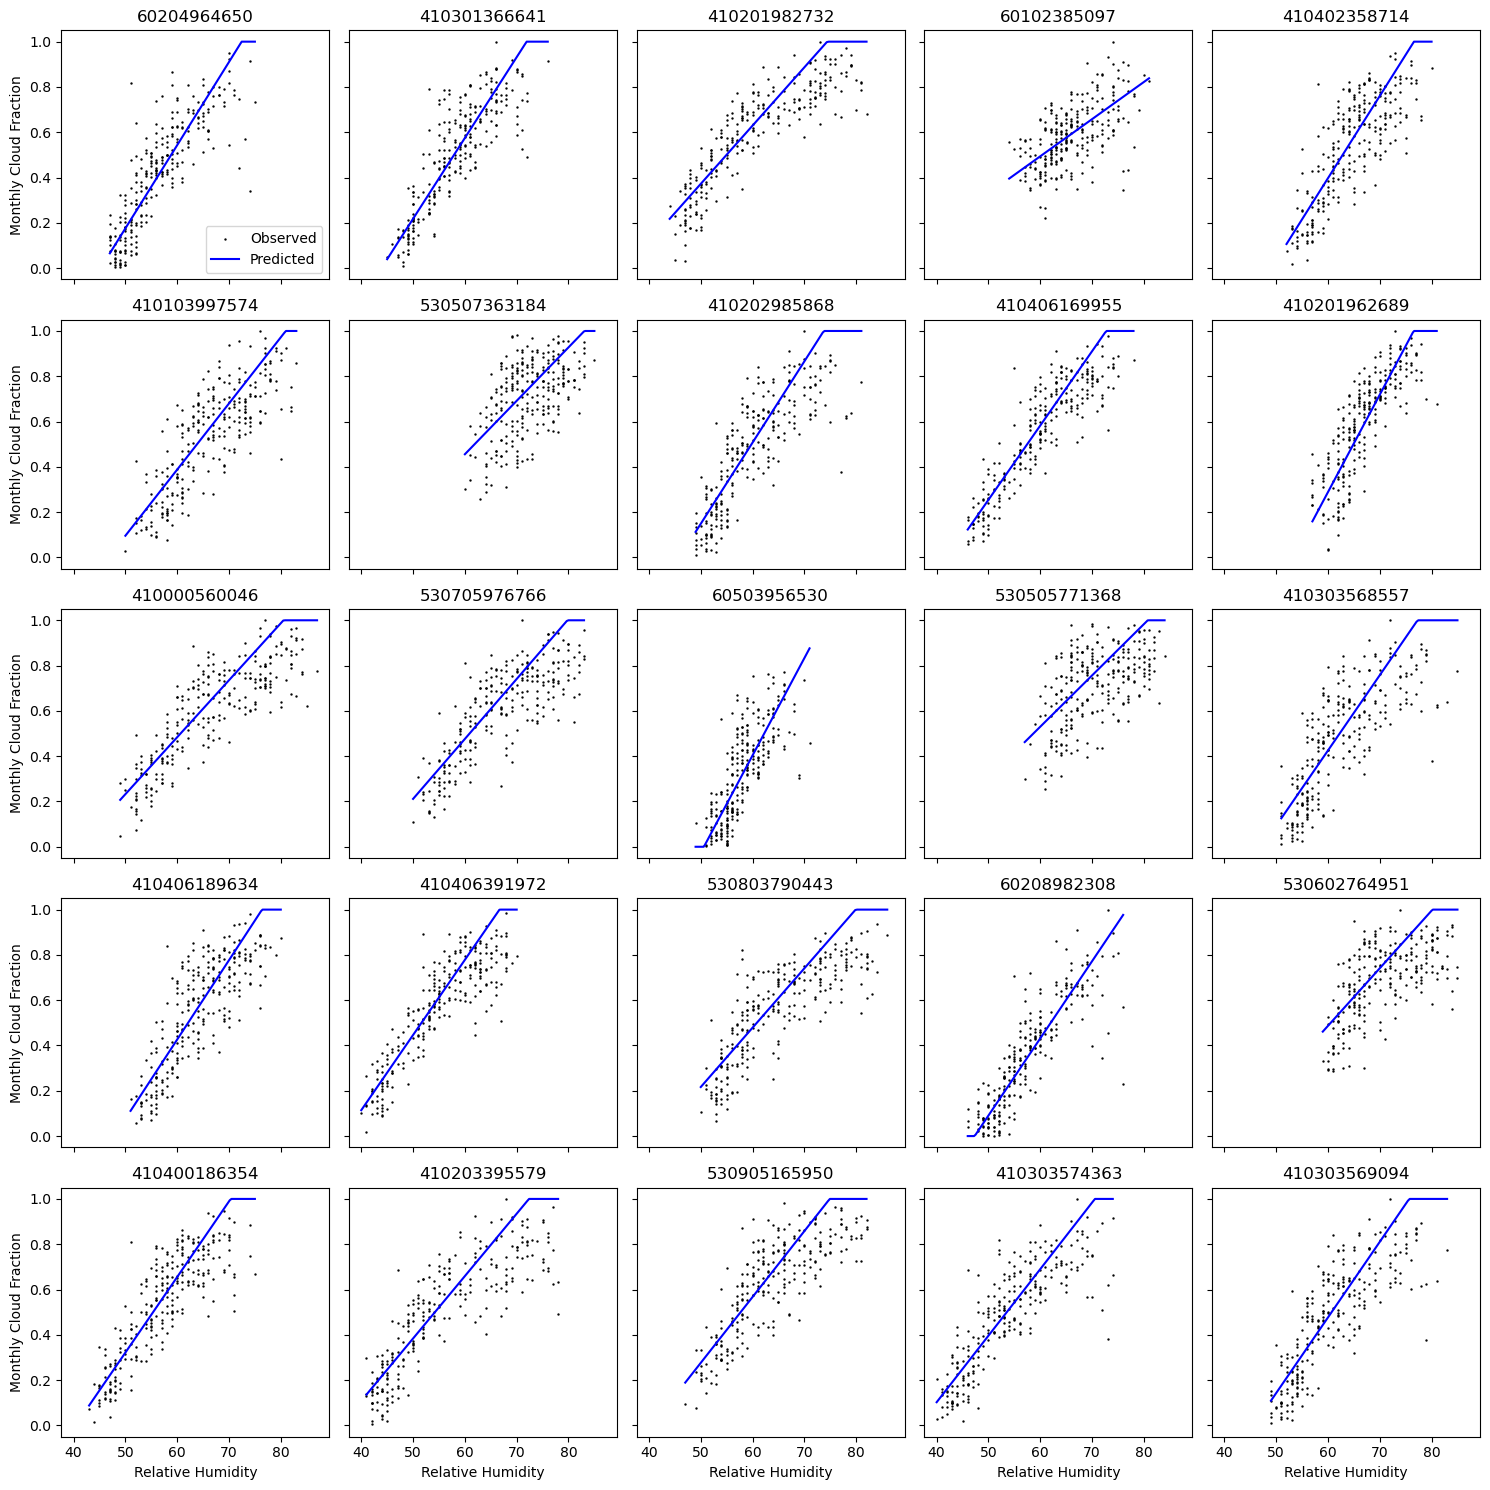

In [15]:
fig, axs = plt.subplots(5,5, figsize=(15,15), sharex=True, sharey=True)

for i, plot in enumerate(plots):
    _, res = fit_linear_cloud(plot)
    coefs = res.x
    cost = res.cost
    x = obs.loc[plot, 'RH'].values
    y = obs.loc[plot, 'CLOUDS'].values
    axs.ravel()[i].scatter(x,  y, color='black', s=0.5, label='Observed')
    axs.ravel()[i].plot(np.linspace(x.min(), x.max(), 100), 
                        np.clip(pred_cloud_cover(coefs[0], coefs[1], coefs[2], np.linspace(x.min(), x.max(), 100), locations.loc[plot, 'ELEV']), 0, 1),
                        color='blue', label='Predicted')
    axs.ravel()[i].set_title(plot)
#     axs.ravel()[i].text(0.05, 0.4, f'{cost:.2f}')
for ax in axs[-1,:]:
    ax.set_xlabel('Relative Humidity')
for ax in axs[:,0]:
    ax.set_ylabel('Monthly Cloud Fraction')
axs.ravel()[0].legend()
plt.tight_layout()
plt.savefig('../reports/figures/example_cloud_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
OVERWRITE = True
OUTFILE = '../data/interim/cloud_linear_coefs.csv'

plot_ids = pd.Series(np.unique(obs.index.get_level_values(0)), dtype=int, name='PLOT_ID')

if OVERWRITE or not os.path.exists(OUTFILE):
    results = pd.DataFrame(index=plot_ids, 
                           columns=['INTERCEPT', 'bRH', 'bELEV'])
else:
    results = pd.read_csv(OUTFILE).set_index('PLOT_ID')

to_run = results.loc[results.INTERCEPT.isna()].index
num_jobs = len(to_run)
with tqdm(total=num_jobs) as pbar:
    with ProcessPoolExecutor(40) as executor:
        jobs = [executor.submit(fit_linear_cloud, idx) for idx in to_run]
        for job in as_completed(jobs):
            idx, res = job.result()
            coefs = res.x
            observed = cloud_cover_correction(obs.loc[idx, 'CLEARSKY_GHI'].values, obs.loc[idx, 'CLOUDS'].values)
            predicted = pred_cloudy_ghi(coefs[0], coefs[1], coefs[2], 
                                        obs.loc[idx, 'RH'].values, 
                                        locations.loc[idx, 'ELEV'],
                                        obs.loc[idx, 'CLEARSKY_GHI'].values, 
                                        clip_clouds=True)
            resid = observed - predicted
            rmse = np.sqrt((resid**2).mean())
            annual_diff_pct = (observed.sum() - predicted.sum()) / observed.sum()
            
            update = pd.Series(coefs, index=['INTERCEPT', 'bRH', 'bELEV'])
            results.loc[idx, ['INTERCEPT', 'bRH', 'bELEV']] = update
            results.loc[idx, 'RMSE'] = rmse
            results.loc[idx, 'ANNUAL_CLOUDY_GHI_PCT_DIFF'] = annual_diff_pct
            pbar.update()

  0%|          | 0/12156 [00:00<?, ?it/s]

In [17]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   INTERCEPT                   12156 non-null  object 
 1   bRH                         12156 non-null  object 
 2   bELEV                       12156 non-null  object 
 3   RMSE                        12156 non-null  float64
 4   ANNUAL_CLOUDY_GHI_PCT_DIFF  12156 non-null  float64
dtypes: float64(2), object(3)
memory usage: 827.9+ KB


In [18]:
results.to_csv(OUTFILE, index=True, header=True)

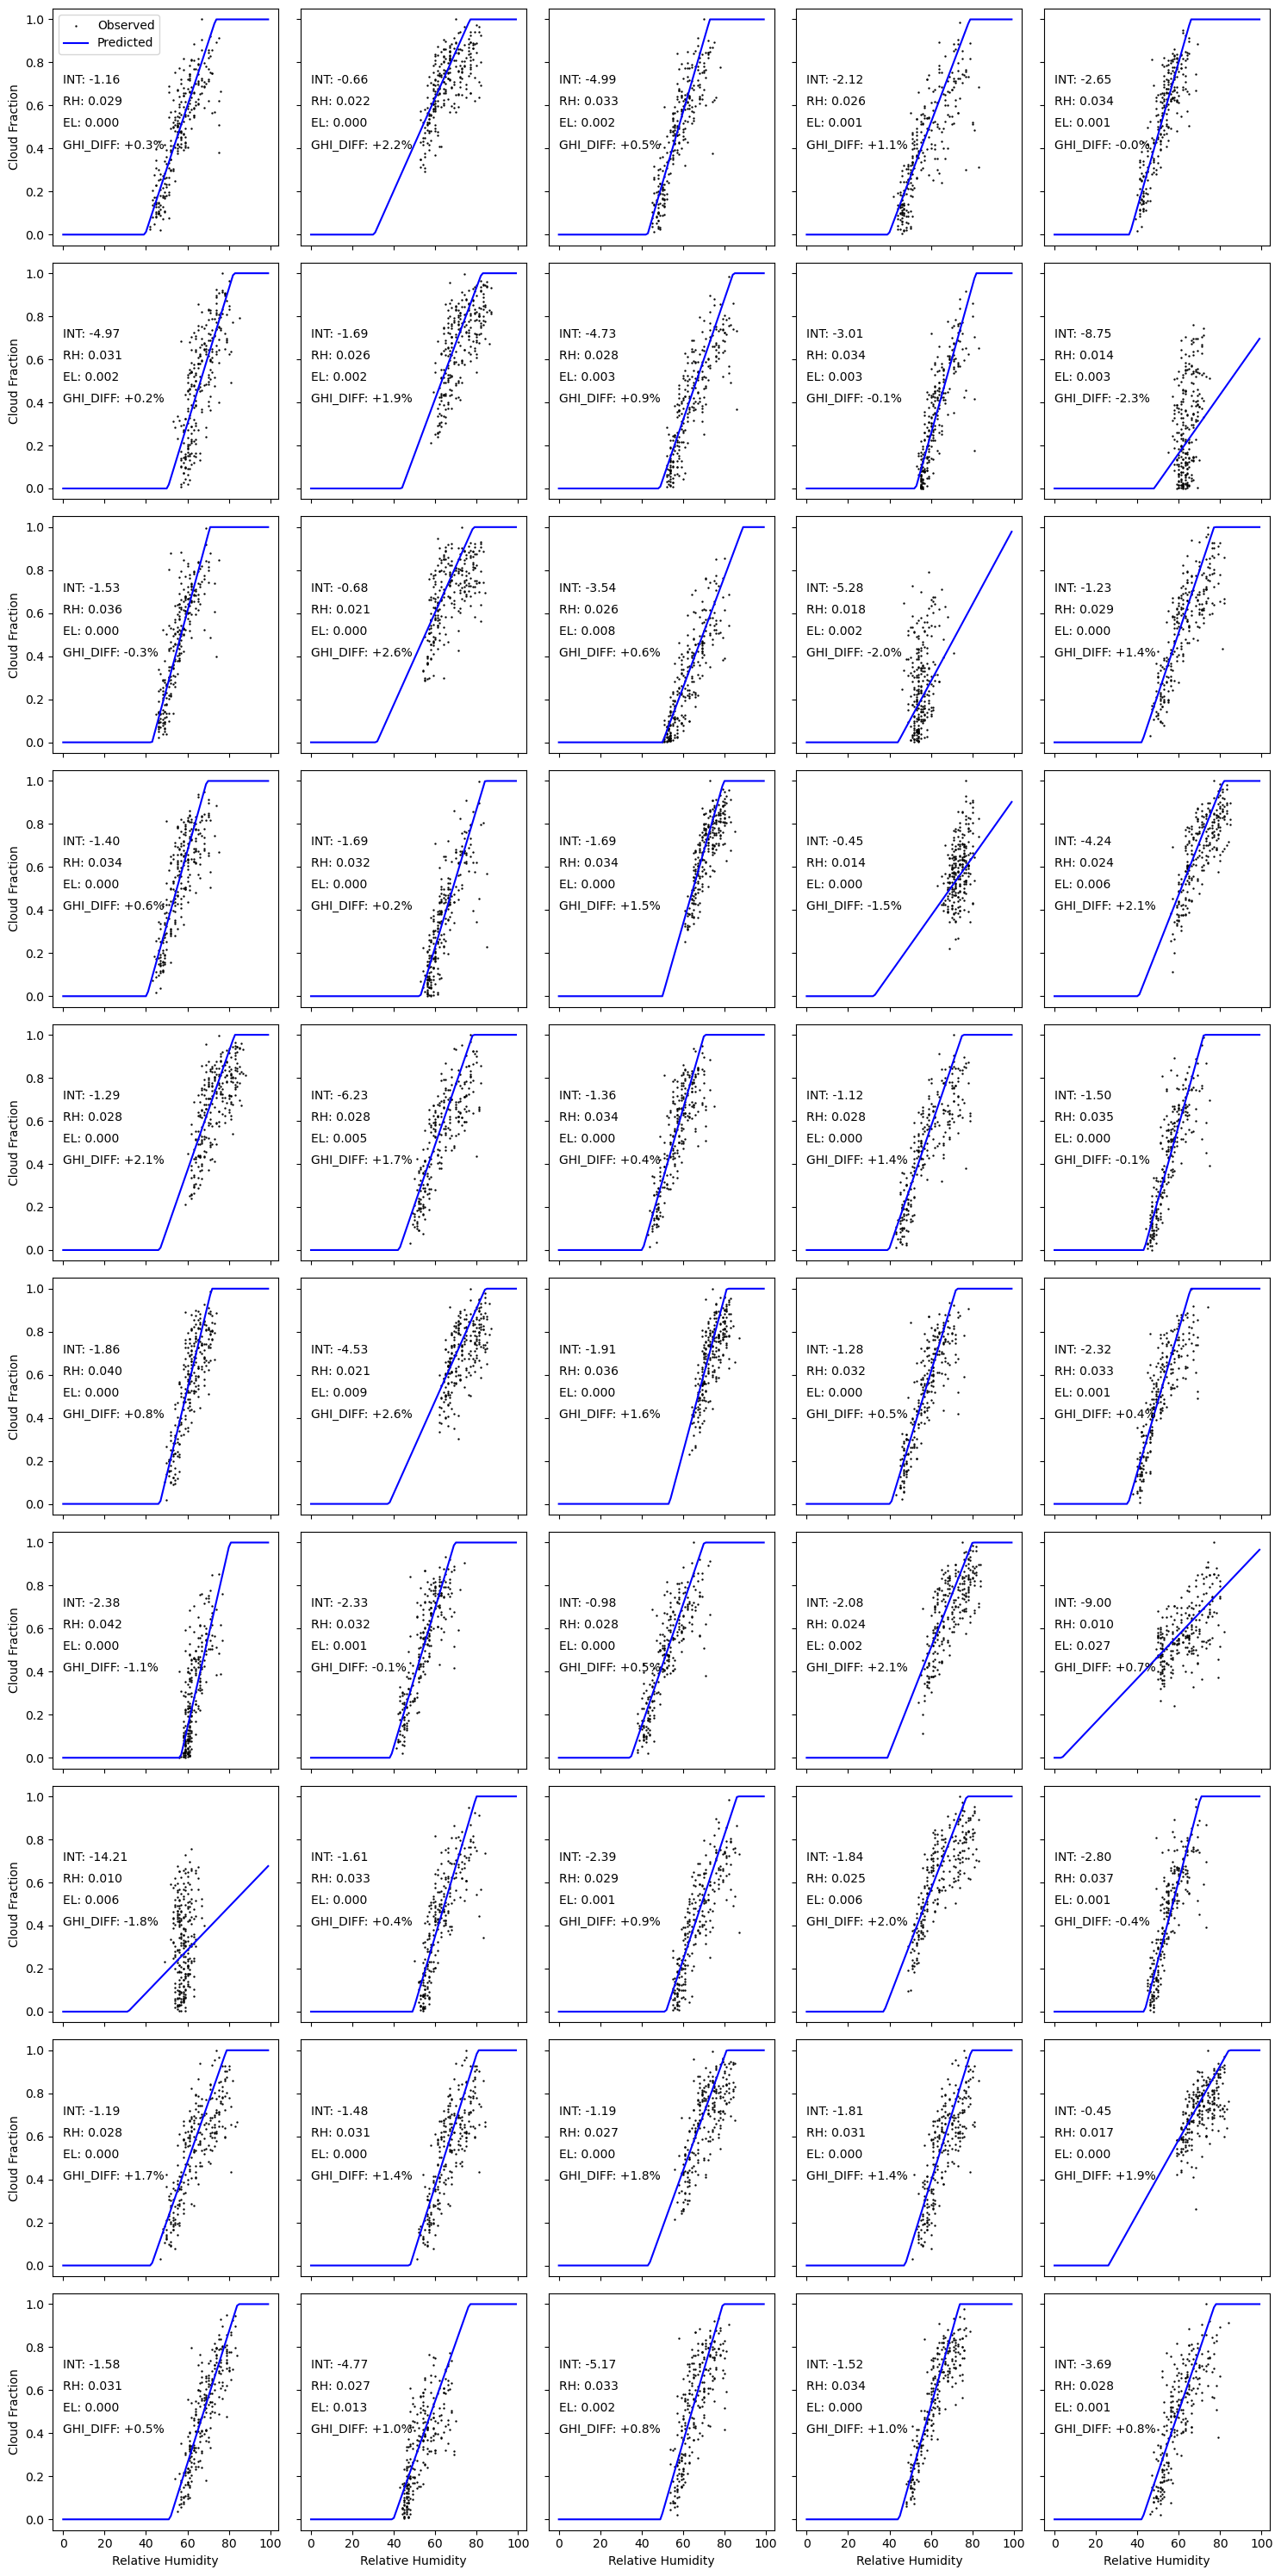

In [21]:
fig, axs = plt.subplots(10,5, figsize=(15,30), sharex=True, sharey=True)
plots = np.random.choice(obs.index.get_level_values(0), 50)

for i, plot in enumerate(plots):
    res = results.loc[plot, ['INTERCEPT', 'bRH', 'bELEV']].values
    cost = results.loc[plot, 'ANNUAL_CLOUDY_GHI_PCT_DIFF']
    axs.ravel()[i].scatter(obs.loc[plot, 'RH'].values, obs.loc[plot, 'CLOUDS'].values, color='black', s=0.5, label='Observed')
    axs.ravel()[i].plot(np.arange(0,100), np.clip(pred_cloud_cover(res[0], res[1], res[2], np.arange(0,100), locations.loc[plot, 'ELEV']),0,1), 
                        color='blue', label='Predicted')
    axs.ravel()[i].text(0.05, 0.7, f'INT: {res[0]:.2f}')
    axs.ravel()[i].text(0.05, 0.6, f'RH: {res[1]:.3f}')
    axs.ravel()[i].text(0.05, 0.5, f'EL: {res[2]:.3f}')
    axs.ravel()[i].text(0.05, 0.4, f'GHI_DIFF: {cost:+.1%}')
axs.ravel()[0].legend()

for ax in axs[:,0]:
    ax.set_ylabel('Cloud Fraction')
for ax in axs[-1,:]:
    ax.set_xlabel('Relative Humidity')
plt.tight_layout()
plt.show()

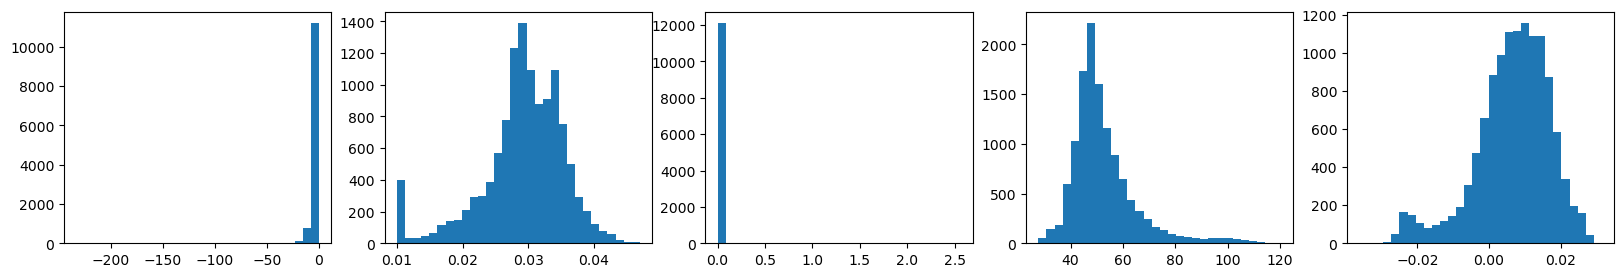

In [20]:
fig, axs = plt.subplots(1,5, figsize=(20,3))
axs[0].hist(results.INTERCEPT, bins=30)
axs[1].hist(results.bRH, bins=30)
axs[2].hist(results.bELEV, bins=30)
axs[3].hist(results.RMSE, bins=30)
axs[4].hist(results.ANNUAL_CLOUDY_GHI_PCT_DIFF, bins=30)
plt.show()